In [2]:
%matplotlib inline

In [3]:
import pandas as pd, numpy as np, glob
from matplotlib import pyplot as plt

from PIL import Image

import scipy.stats as ss, seaborn as sns
## Bring in more mods
from matplotlib.gridspec import GridSpec
plt.style.use(['tableau-colorblind10'])

def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

from matplotlib import rc
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

kb = 1000

In [4]:
## Bring in genotype data and find unique test loci
## Bring in genotype data
geno_path = '~/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(geno_path)

## find unique chromosomes, lengths, and midpoints. 
chrlist = sorted(gv.Chrom.unique())
chrlens = np.array([gv[(gv.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + gv[(gv.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos
assert len(chrlist) == 14

In [5]:
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [6]:
import os

In [7]:
import statsmodels.formula.api as smf

In [8]:
dgg = pd.read_csv('./Cdeneoformans_capsule_phenotypes.csv')
dgg.drop('Sample.1',inplace=True,axis=1)
dgg.index = dgg.Sample
segs = dgg.Sample.unique()
assert dgg.Sample.unique().shape[0] == dgg.shape[0]
len(segs)

104

In [9]:
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL
Sample,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1.0
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1.0
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0.0
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1.0
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0.0


In [10]:
## conduct QTL mapping
test = gv[segs].drop_duplicates()

In [11]:
phenos = dgg.columns.tolist()[2:8]

In [12]:
phenos

['Cell_and_Capsule',
 'Cell',
 'Capsule',
 'Cell_and_Capsule_diameter',
 'Cell_diameter',
 'Capsule_diameter']

In [13]:
test.shape

(2777, 104)

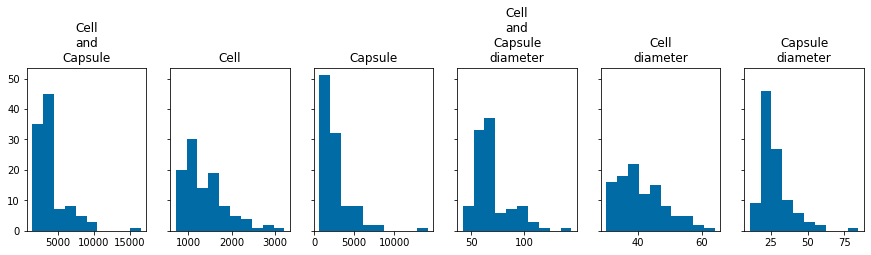

In [14]:
fig,ax = plt.subplots(1,len(phenos),figsize=(15,3),sharey=True)

for i,p in enumerate(phenos):
    
    plt.sca(ax.ravel()[i])
    plt.hist(dgg[p].values);
    plt.title('\n'.join(p.split('_')))

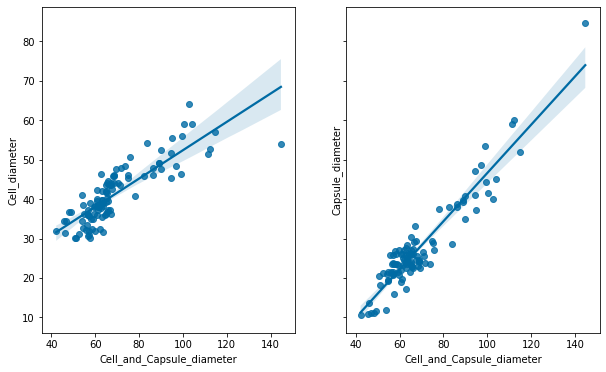

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,6),sharex=True,sharey=True);

plt.sca(ax[0]);
sns.regplot(x=phenos[3],y=phenos[4],data=dgg,order=1);

plt.sca(ax[1])
sns.regplot(x=phenos[3],y=phenos[5],data=dgg,order=1);

In [16]:
cell_lin_mod = smf.ols('Cell_diameter ~ Cell_and_Capsule_diameter',data=dgg).fit()
cell_lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cell_diameter   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     246.4
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           5.76e-29
Time:                        12:45:31   Log-Likelihood:                -291.17
No. Observations:                 104   AIC:                             586.3
Df Residuals:                     102   BIC:                             591.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    16.4867      1.625     10.144      0.000      13.263      19.710
Cell_and_Capsule_diameter     0.3587      0.023     15.698      0.000       0.313       0.404
==============================================================================
Omnibus:                        3.473   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.020
Skew:                          -0.259   Prob(JB):                        0.221
Kurtosis:                       3.654   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
ss.shapiro(cell_lin_mod.resid)

(0.9871662259101868, 0.42011958360671997)

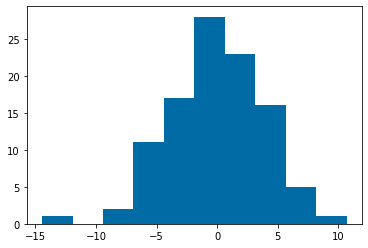

In [18]:
plt.hist(cell_lin_mod.resid);

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
x = dgg[phenos[3]].values.reshape(-1,1)

In [21]:
x.shape

(104, 1)

In [22]:
polynomial_features= PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(x)
xp.shape

(104, 3)

In [23]:
import statsmodels.api as sm

In [24]:
phenos

['Cell_and_Capsule',
 'Cell',
 'Capsule',
 'Cell_and_Capsule_diameter',
 'Cell_diameter',
 'Capsule_diameter']

In [25]:
model = sm.OLS(dgg[phenos[4]].values, xp).fit()
ypred = model.predict(xp) 

ypred.shape

(104,)

In [26]:
ss.shapiro(model.resid)

(0.9902018308639526, 0.6548328995704651)

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     160.0
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           4.94e-32
Time:                        12:45:31   Log-Likelihood:                -280.83
No. Observations:                 104   AIC:                             567.7
Df Residuals:                     101   BIC:                             575.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3900      5.072     -1.260      0.211     -16.452       3.672
x1             0.9545      0.128      7.453      0.000       0.700       1.209
x2            -0.0036      0.001     -4.715      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        0.984   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                1.003
Skew:                           0.105   Prob(JB):                        0.606
Kurtosis:                       2.567   Cond. No.                     8.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

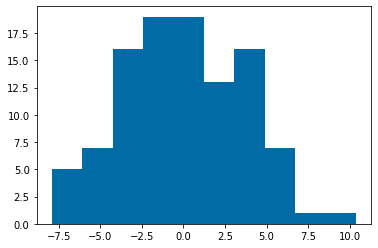

In [28]:
plt.hist(model.resid);

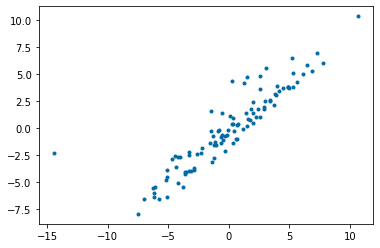

In [29]:
plt.plot(cell_lin_mod.resid,model.resid,'.');

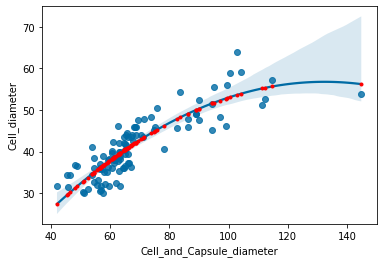

In [30]:
sns.regplot(x=phenos[3],y=phenos[4],data=dgg,order=2);
plt.plot(dgg[phenos[3]],ypred,'r.');

In [31]:
caps_mod = smf.ols('Capsule_diameter ~ Cell_and_Capsule_diameter',data=dgg).fit()
caps_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Capsule_diameter   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     828.7
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           8.93e-51
Time:                        12:45:32   Log-Likelihood:                -283.42
No. Observations:                 104   AIC:                             570.8
Df Residuals:                     102   BIC:                             576.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -14.4648      1.508     -9.589      0.000     -17.457     -11.473
Cell_and_Capsule_diameter     0.6105      0.021     28.787      0.000       0.568       0.653
==============================================================================
Omnibus:                        0.228   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.408
Skew:                           0.035   Prob(JB):                        0.816
Kurtosis:                       2.701   Cond. No.                         294.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
dgg['Predicted'] = caps_mod.predict()

In [33]:
dgg['Cell_Diameter_Residual'] = cell_lin_mod.resid#model.resid
dgg['Capsule_Diameter_Residual'] = caps_mod.resid

In [34]:
test['Predict'] = test[segs].apply(association_logPval,args=[dgg.T[segs].T[p]],axis=1 )

In [35]:
predict_test = gv.merge(test)

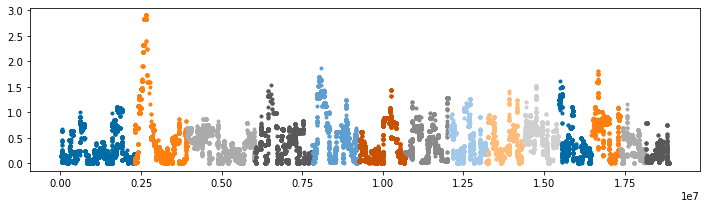

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i,c in enumerate(chrlist):
    
    temp = predict_test[(predict_test.Chrom==c)]
    
    plt.plot(temp.Pos.values+cumpos[i],temp.Predict,'.');

In [37]:
for p in phenos:

    test[p] = test[segs].apply(association_logPval,
                               args=[dgg.T[segs].T[p]],
                               axis=1)
pval_df = gv.merge(test)

In [38]:
phenos

['Cell_and_Capsule',
 'Cell',
 'Capsule',
 'Cell_and_Capsule_diameter',
 'Cell_diameter',
 'Capsule_diameter']

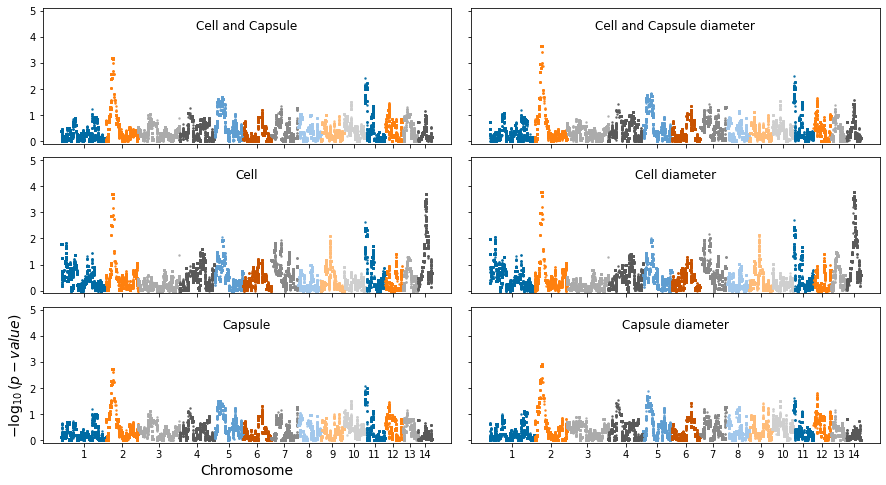

In [39]:
fig,ax = plt.subplots(3,2,figsize=(15,8),sharex=True,sharey=True)

plot_map = [0,2,4,1,3,5]
for i,p in enumerate(phenos):
    plt.sca(ax.ravel()[plot_map[i]])
    plt.title(' '.join(p.split('_')),y=.8)
    plt.xticks(chrmid,1+np.arange(len(chrlist)))
    
    for c,chrom in enumerate(chrlist):
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,alpha=0.8)
plt.ylim(-0.1,5.1)
plt.subplots_adjust(hspace=0.1,wspace=0.05)
plt.sca(ax[-1,0])
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosome',fontsize=14);

In [40]:
residuals_phenos = ['Cell_Diameter_Residual',
       'Capsule_Diameter_Residual']

In [41]:
test.shape

(2777, 111)

In [42]:
for p in residuals_phenos:

    test[p] = test[segs].apply(association_logPval,
                               args=[dgg.T[segs].T[p]],
                               axis=1)
    pval_df[p] = gv.merge(test)[p]

In [43]:
pval_df.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B382,Predict,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Cell_Diameter_Residual,Capsule_Diameter_Residual
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,0.0,0.136843,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,0.0,0.136843,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,0.0,0.136843,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,0.0,0.136843,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,0.0,0.136843,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446


In [44]:
residual_threshold = 4.17#4.1267

kbs = 1000
perms = []
p = dgg.columns[-1]
while len(perms) < kbs:
    
    perms.append(test[segs].apply(association_logPval,
                               args=[np.random.permutation(dgg.T[segs].T[p].values)],
                               axis=1).max())

In [45]:
#cap_res_99 = np.percentile(perms,99)
cap_res_99 = 5.053298755681106

In [46]:
#cap_res_95 = np.percentile(perms,95)
cap_res_95 = 4.187824559247485

In [47]:
cell_res_95 = 4.68

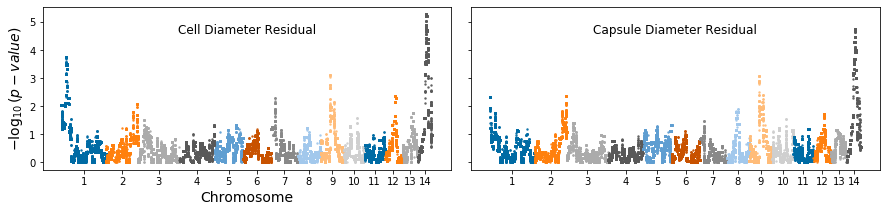

In [48]:
fig,ax = plt.subplots(1,2,figsize=(15,3),sharex=True,sharey=True)


for i,p in enumerate(residuals_phenos):
    plt.sca(ax.ravel()[i])
    plt.title(' '.join(p.split('_')),y=.8)
    plt.xticks(chrmid,1+np.arange(len(chrlist)))
    
    for c,chrom in enumerate(chrlist):
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,alpha=0.8)
        
    
    #plt.hlines(5.05,0,19*(10**6),linewidth=0.5,linestyle='--')
plt.sca(ax[0])
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosome',fontsize=14)
plt.subplots_adjust(hspace=0.1,wspace=0.05)

In [49]:
ch14 = pval_df[(pval_df.Chrom=='Chr14')]

In [50]:
caps_diam_qtl = pval_df.T[ch14['Capsule_Diameter_Residual'].idxmax()].T[segs]

In [51]:
cell_diam_qtl = pval_df.T[ch14['Cell_Diameter_Residual'].idxmax()].T[segs]

In [52]:
dgg['Cell_Diameter_Residual_QTL'] = cell_diam_qtl
dgg['Capsule_Diameter_Residual_QTL'] = caps_diam_qtl

In [53]:
_431_label

'431$\\mathrm{\\alpha}$'

In [54]:
dgg['Chromosome 14\nQTL Allele'] = [_431_label if a == 1 else xl280_label for a in dgg.Cell_Diameter_Residual_QTL]

In [55]:
caps_mod.rsquared

0.8904049276813922

In [56]:
cell_lin_mod.rsquared

0.7072636072990139

In [57]:
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL,Predicted,Cell_Diameter_Residual,Capsule_Diameter_Residual,Cell_Diameter_Residual_QTL,Capsule_Diameter_Residual_QTL,Chromosome 14\nQTL Allele
Sample,,,,,,,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1.0,22.972684,-1.179139,2.144624,1,1,431$\mathrm{\alpha}$
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1.0,23.359906,-6.198297,3.635013,1,1,431$\mathrm{\alpha}$
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0.0,40.518235,3.725538,-5.550718,0,0,XL280$\bf{a}$
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1.0,25.068117,-3.615184,1.251042,1,1,431$\mathrm{\alpha}$
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0.0,43.197154,-5.096695,3.982097,0,0,XL280$\bf{a}$


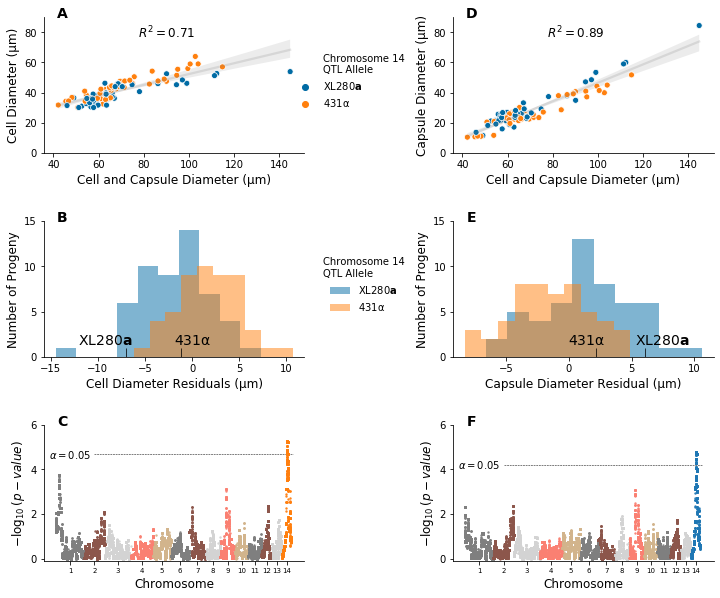

In [58]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
plt.sca(ax[0,0])
plt.title('A',x=0.07,y=.95,fontsize=14,fontweight='bold')
sns.regplot(x='Cell_and_Capsule_diameter',y='Cell_diameter',
            data=dgg,order=1,scatter_kws={'alpha':0.0},
            line_kws={'color':'grey','alpha':0.2});

sns.scatterplot(x='Cell_and_Capsule_diameter',y='Cell_diameter',
                hue='Chromosome 14\nQTL Allele',data=dgg,
                hue_order=[xl280_label,_431_label],legend=None);

plt.xlabel('Cell and Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylabel('Cell Diameter (\u03BCm)',fontsize=12)
plt.ylim(0,90)
plt.text(x=90,y=80,s='$R^2 = %s$'%np.round(cell_lin_mod.rsquared,2),
         va='center',ha='center',fontsize=12)


plt.sca(ax[1,0])
plt.title('B',x=0.07,y=.95,fontsize=14,fontweight='bold')

plt.hist(dgg[(dgg.Cell_Diameter_Residual_QTL==0)
            ].Cell_Diameter_Residual.values,alpha=0.5,label=xl280_label)
plt.hist(dgg[(dgg.Cell_Diameter_Residual_QTL==1)
            ].Cell_Diameter_Residual.values,alpha=0.5,label=_431_label)
plt.ylabel('Number of Progeny',fontsize=12)
plt.ylim(0,15)
plt.yticks(np.arange(0,20,5))



plt.xlabel('Cell Diameter Residuals (\u03BCm)',fontsize=12)

plt.vlines(dgg.T[['XL280a','SS-A837']].T.Cell_Diameter_Residual.values,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Cell_Diameter_Residual-0.75,y=1,
         s=_431_label,fontsize=14,va='bottom',ha='left')
plt.text(x=dgg.T['XL280a'].T.Cell_Diameter_Residual+0.75,y=1,
         s=xl280_label,fontsize=14,va='bottom',ha='right');


plt.sca(ax[0,1])
plt.title('D',x=0.07,y=.95,fontsize=14,fontweight='bold')

sns.regplot(x='Cell_and_Capsule_diameter',y='Capsule_diameter',
            data=dgg,order=1,scatter_kws={'alpha':0.0},
            line_kws={'color':'grey','alpha':0.2});

sns.scatterplot(x='Cell_and_Capsule_diameter',y='Capsule_diameter',
                hue='Chromosome 14\nQTL Allele',data=dgg,
                hue_order=[xl280_label,_431_label]);
plt.legend(frameon=False,bbox_to_anchor=(-.15,.8))

plt.xlabel('Cell and Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylabel('Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylim(0,90)
plt.text(x=90,y=80,s='$R^2 = %s$'%np.round(caps_mod.rsquared,2),
         va='center',ha='center',fontsize=12)



plt.sca(ax[1,1])
plt.title('E',x=0.07,y=.95,fontsize=14,fontweight='bold')

plt.hist(dgg[(dgg.Capsule_Diameter_Residual_QTL==0)
            ].Capsule_Diameter_Residual.values,alpha=0.5,label=xl280_label)
plt.hist(dgg[(dgg.Capsule_Diameter_Residual_QTL==1)
            ].Capsule_Diameter_Residual.values,alpha=0.5,label=_431_label)


plt.legend(title='Chromosome 14\nQTL Allele',
           fontsize=10,frameon=False,bbox_to_anchor=(-.15,.8))
plt.ylabel('Number of Progeny',fontsize=12)
plt.xlabel('Capsule Diameter Residual (\u03BCm)',fontsize=12)
plt.ylim(0,15)
plt.yticks(np.arange(0,20,5))
plt.vlines(dgg.T[['XL280a','SS-A837']].T.Capsule_Diameter_Residual.values,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Capsule_Diameter_Residual+0.75,y=1,
         s=_431_label,fontsize=14,va='bottom',ha='right')
plt.text(x=dgg.T['XL280a'].T.Capsule_Diameter_Residual-0.75,y=1,
         s=xl280_label,fontsize=14,va='bottom',ha='left');

thresholds = [cell_res_95,cap_res_95]
QTL_color= ['tab:orange','tab:blue']
for i,p in enumerate(residuals_phenos):
    plt.sca(ax[-1,i])
    plt.title('C' if i == 0 else 'F',x=0.07,y=.95,fontsize=14,fontweight='bold')

    plt.xticks(chrmid,1+np.arange(len(chrlist)),fontsize=7)
    plt.hlines(thresholds[i],chrmid[1],19*(10**6),
               linestyle='--',linewidth=0.5)
    
    plt.text(x=chrmid[0],y=thresholds[i],
             s=r'$\alpha = 0.05$',va='center',ha='center')
    
    for c,chrom in enumerate(chrlist):
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,
                 alpha=0.8,
                 color=QTL_color[i] if chrom == 'Chr14' 
                 else chrom_colors[c%len(chrom_colors)])
        
    plt.ylim(-0.1,6)
    plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);
    plt.xlabel('Chromosome',fontsize=12)


for i in range(6):
    [ax.ravel()[i].spines[a].set_visible(False) for a in ['top','right']]

plt.subplots_adjust(hspace=0.5,wspace=0.57)
#plt.savefig('./Capsule_Cell_Residuals_QTL.png',
plt.savefig('/home/croth/QTL_FIGS/SUPP/FIGS/S2_Fig.pdf',
            dpi=300,bbox_inches='tight');

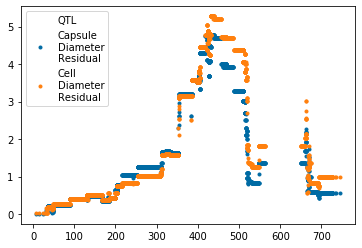

In [58]:
[plt.plot(ch14.Pos/kb,
        ch14[p].values,'.',label='\n'.join(p.split('_'))) 
 for p in residuals_phenos[::-1]];
plt.legend(title='QTL');

In [59]:
dgg[(dgg.Capsule_diameter>75)]

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL,Predicted,Cell_Diameter_Residual,Capsule_Diameter_Residual,Cell_Diameter_Residual_QTL,Capsule_Diameter_Residual_QTL,Chromosome 14\nQTL Allele
Sample,,,,,,,,,,,,,,,,,
SS-B364,SS-B364,nd,16556.5,2292.0,14235.0,144.75283,53.960829,84.486981,15,10.581925,0.0,73.905056,-14.448096,10.581925,0,0,XL280$\bf{a}$


In [60]:
dgg[(dgg.Capsule_diameter == dgg.Capsule_diameter.max())]

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL,Predicted,Cell_Diameter_Residual,Capsule_Diameter_Residual,Cell_Diameter_Residual_QTL,Capsule_Diameter_Residual_QTL,Chromosome 14\nQTL Allele
Sample,,,,,,,,,,,,,,,,,
SS-B364,SS-B364,nd,16556.5,2292.0,14235.0,144.75283,53.960829,84.486981,15,10.581925,0.0,73.905056,-14.448096,10.581925,0,0,XL280$\bf{a}$


In [61]:
ch14_temp = pval_df[(pval_df.Chrom=='Chr14')].copy()

In [62]:
#Melpvals = pd.read_csv('/Users/croth/Downloads/Melanin_QTL_pvalues.csv',index_col=0)
#MelQTL = pd.read_csv('/Users/croth/Downloads/Melanin_QTL_Genotype_phenotype.csv')
#Melanin = pd.read_csv('../../FILES/Melanin_Phenotypes.csv',index_col=0)
#ric8 = pd.read_csv('../../FILES/Chr14/CNN01270.csv',index_col=0)
#gff = pd.read_csv('../../FILES/xl280genome.gff3.csv.gz',index_col=0)

In [63]:
melanin_pval = pd.read_csv('./Melanin_QTL_pvalues.csv',index_col=0)

In [64]:
ci95_mel = np.array([368955, 403449])# (354015,403043)
ci95_res = np.array([354579, 667688.05]) # (354015,431009)

In [65]:
pval_df['Mel'] = melanin_pval.Melanin

In [66]:
ch14 = pval_df[(pval_df.Chrom=='Chr14')]
ch14.shape

(3498, 135)

In [67]:
dgg['QTL'] = dgg['Capsule_Diameter_Residual_QTL']

In [68]:
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL,Predicted,Cell_Diameter_Residual,Capsule_Diameter_Residual,Cell_Diameter_Residual_QTL,Capsule_Diameter_Residual_QTL,Chromosome 14\nQTL Allele
Sample,,,,,,,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1,22.972684,-1.179139,2.144624,1,1,431$\mathrm{\alpha}$
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1,23.359906,-6.198297,3.635013,1,1,431$\mathrm{\alpha}$
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0,40.518235,3.725538,-5.550718,0,0,XL280$\bf{a}$
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1,25.068117,-3.615184,1.251042,1,1,431$\mathrm{\alpha}$
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0,43.197154,-5.096695,3.982097,0,0,XL280$\bf{a}$


In [69]:
mod_res = smf.ols('Capsule_Diameter_Residual ~ QTL',data=dgg).fit()
cap_res_r = np.round(mod_res.rsquared,2)

In [70]:
cap_res_r

0.17

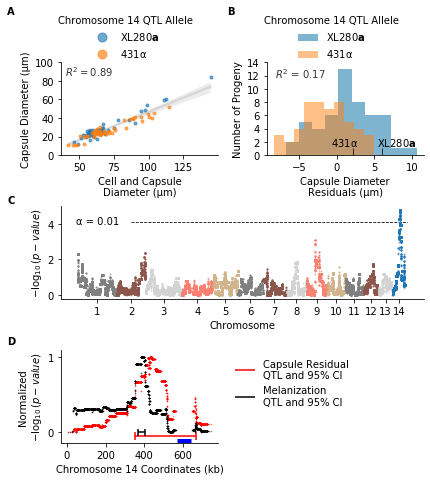

In [175]:
residual_threshold = 4.1267
width = 6.5
height = 7
fig = plt.figure(figsize=(width,height))
gs = fig.add_gridspec(3,4)
fs = 10
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,:2])

plt.sca(ax1)
[ax1.spines[a].set_visible(False) for a in ['top','right']]
x = 'Cell_and_Capsule_diameter'
y = 'Capsule_diameter'
plt.text(40,90,'$R^2 = %s$'%np.round(caps_mod.rsquared,2),
         fontsize=fs,color='k',va='center',alpha=.8)

sns.regplot(x=x,y=y,
           data=dgg,order=1,
           line_kws={'color':'grey','alpha':.2}, 
           scatter_kws={'color':'k','alpha':0.0});

plt.plot(dgg[(dgg.QTL==0)][x].values,
         dgg[(dgg.QTL==0)][y].values,'.',
         color='tab:blue',alpha=0.64,label=xl280_label)

plt.plot(dgg[(dgg.QTL==1)][x].values,
         dgg[(dgg.QTL==1)][y].values,'.',
         color='tab:orange',alpha=0.64,label=_431_label)

plt.legend(title='Chromosome 14 QTL Allele',markerscale=3.0,
           fontsize=fs, bbox_to_anchor=(0.9,1.6),frameon=False)

plt.ylabel('Capsule Diameter (\u03BCm)',fontsize=fs)
plt.xlabel('Cell and Capsule\nDiameter (\u03BCm)',fontsize=fs)
plt.yticks(np.arange(0,120,20))    

plt.sca(ax2)

for i, a in enumerate(dgg.groupby('QTL')):
    
    plt.hist(a[1].Residual,alpha=0.5,bins=10,
    label=xl280_label if i == 0 else _431_label);

plt.vlines(dgg.T[['XL280a','SS-A837']].T.Residual,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Residual+0.75,y=1,
         s=_431_label,fontsize=fs,va='bottom',ha='right')
plt.text(x=dgg.T['XL280a'].T.Residual-0.75,y=1,
         s=xl280_label,fontsize=fs,va='bottom',ha='left');
plt.xlabel('Capsule Diameter\nResiduals (\u03BCm)',fontsize=fs);
plt.ylabel('Number of Progeny',fontsize=fs);
plt.yticks(np.arange(0,16,2))
plt.legend(title='Chromosome 14 QTL Allele',
           fontsize=fs, bbox_to_anchor=(0.9,1.6),frameon=False)
[ax2.spines[a].set_visible(False) for a in ['top','right']]
plt.text(-1.5,12.4,s='$R^2$ = %s'%cap_res_r,va='center',
         ha='right',fontsize=fs,rasterized=True,
         color='k',alpha=.8)

###### ----------------------------------------------------------- ######
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']
plt.sca(ax3)
[ax3.spines[a].set_visible(False) for a in ['top','right']]
for c in chrlist:
    i = int(c[-2:]) -1
    if c == 'Chr14':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[i%len(chrom_colors)]
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],
             temp.Capsule_Diameter_Residual.values,
             '.',alpha=0.5,markersize=2,color=cc)
plt.hlines(residual_threshold,chrmid[1],19*(10**6),linestyle='--',
           linewidth=0.8)#,label='\u03B1 = 0.01')
plt.xticks(chrmid,[int(a[-2:]) for a in chrlist]);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=fs);
plt.xlabel('Chromosome',fontsize=fs)
plt.text(x=chrmid[0],y=residual_threshold ,s='\u03B1 = 0.01',
         va='center',ha='center',fontsize=fs)    
    
###### ----------------------- Capsule and Melanin QTL overlap plot -------------------- #######    
plt.sca(ax4)

[ax4.spines[a].set_visible(False) for a in ['top','right']]
kb = 1000
yp = -0.05
ls = 0.05
plt.plot(ch14.Pos.values/kb,myminmax(ch14.Capsule_Diameter_Residual.values),
         'r.',alpha=0.5,markersize=1)
plt.hlines(yp,*ci95_res/kb,color='r', label='Capsule Residual\nQTL and 95% CI');
plt.vlines(ci95_res/kb,yp-ls,yp+ls,color='r');

plt.plot(ch14.Pos.values/kb,myminmax(ch14.Mel.values),'.k',
         alpha=0.5,markersize=1)
plt.hlines(yp+0.05,*ci95_mel/kb,color='k',label='Melanization\nQTL and 95% CI');
plt.vlines(ci95_mel/kb ,yp+0.05-ls,yp+0.05+ls,color='k');#

plt.hlines(-0.13,568029/kb,644419/kb,color='blue',linewidth=7);     
plt.ylim(-0.14,1.1)
plt.yticks([0,1])
plt.legend(bbox_to_anchor=(1.05,1),fontsize=fs,frameon=False);
plt.xlabel('Chromosome 14 Coordinates (kb)',fontsize=fs);
plt.ylabel('Normalized\n$-\log_{10}\,(p-value)$',fontsize=fs);

plt.subplots_adjust(wspace=0.9,hspace=0.55)


fig.text(0.01,.975,'A',fontsize=fs,fontweight='bold')
fig.text(0.48,.975,'B',fontsize=fs,fontweight='bold')
fig.text(0.01,.6,'C',fontsize=fs,fontweight='bold')
fig.text(0.01,.32,'D',fontsize=fs,fontweight='bold')

mydpi = 600
qtlpaper_save = './QTL_FIGS/Fig2.tiff'
plt.savefig(qtlpaper_save,
           dpi=mydpi,bbox_inches='tight',compression='tiff_lzw');

im = Image.open(qtlpaper_save)
w,h = im.size

assert w/mydpi > 2.63
assert w/mydpi < 7.5
assert h/mydpi < 8.5
    
im.save(qtlpaper_save,compression='tiff_lzw')

In [161]:
im = Image.open('/home/croth/QTL_FIGS/test2.tiff')
w,h = im.size

In [162]:
w/300,w

(5.536666666666667, 1661)

In [163]:
h/300,h

(6.67, 2001)

In [59]:
ss.normaltest(dgg.Cell_diameter.values)

NormaltestResult(statistic=8.213004117023905, pvalue=0.016465268458116723)

In [60]:
ss.shapiro(dgg.Cell_diameter.values)

(0.9558315277099609, 0.00159282679669559)

In [61]:
ss.normaltest(np.log(dgg.Cell_diameter.values))

NormaltestResult(statistic=3.1206735900164433, pvalue=0.2100653103375586)

In [62]:
ss.shapiro(np.log(dgg.Cell_diameter.values))

(0.9783492088317871, 0.08625141531229019)

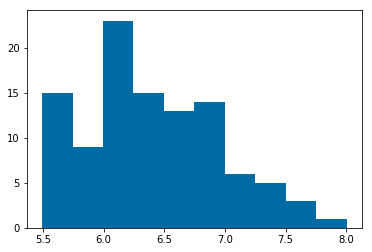

In [63]:
plt.hist(np.sqrt(dgg.Cell_diameter.values));

In [122]:
def crypto_kruskal(site,pheno):
    refxpheno = np.array(pheno,dtype=float)[np.array(site)==0]
    altxpheno = np.array(pheno,dtype=float)[np.array(site)==1]
    return -np.log10(ss.kruskal(refxpheno,altxpheno)[1])

In [143]:
## conduct QTL mapping
test = gv[dgg.Sample.unique()].drop_duplicates()

test['Capsule_diameter'] = test.apply(crypto_kruskal,
                             args=[np.log(np.array(dgg.T[dgg.Sample.unique()].T['Cell_diameter'].values,float)) ],axis=1)
pval_df = gv.merge(test)

In [144]:
pval_df.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Capsule_diameter
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.141716
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.141716
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.141716
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.141716
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.141716


perms = []
kbs = 1000

while len(perms) < kbs:
    
    mp = test[segs].apply(association_logPval,
        args=[np.random.permutation(np.log(np.array(dgg.T[segs].T['Capsule_diameter'].values,float)))],
                    axis=1).max()
    perms.append(mp)

4.17

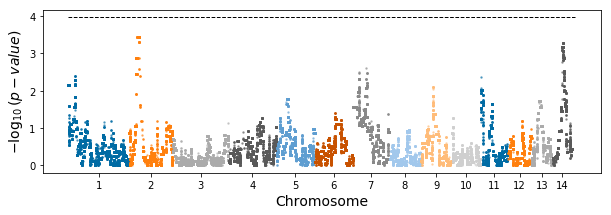

In [147]:
#plt.title(label='C',fontweight='bold',fontsize=14,x=0,y=1)
fig,ax=plt.subplots(1,1,figsize=(10,3))
for i,c in enumerate(chrlist):
    
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],
             temp.Capsule_diameter.values,
             '.',alpha=0.5,markersize=3);
plt.hlines(np.percentile(perms,95),0,19*(10**6),linestyle='--',
           linewidth=1)#,label='\u03B1 = 0.01')
plt.xticks(chrmid,[int(a[-2:]) for a in chrlist]);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosome',fontsize=14);
#plt.text(x=chrmid[0],y=cell_diameter_threshold ,s='\u03B1 = 0.01',
#         va='center',ha='center',fontsize=14);

In [136]:
((test.shape[0]**2) - test.shape[0])/2

3854476.0

In [104]:
chr2ix = pval_df[(pval_df.Chrom=='Chr02')].Cell_size.idxmax()

In [112]:
chr14ix = pval_df[(pval_df.Chrom=='Chr14')].Cell_size.idxmax()

In [110]:
dgg['Cell_diameter_QTL2']=np.array(pval_df.T[chr2ix].T[dgg.index],dtype=float)

In [113]:
dgg['Cell_diameter_QTL14']=np.array(pval_df.T[chr14ix].T[dgg.index],dtype=float)

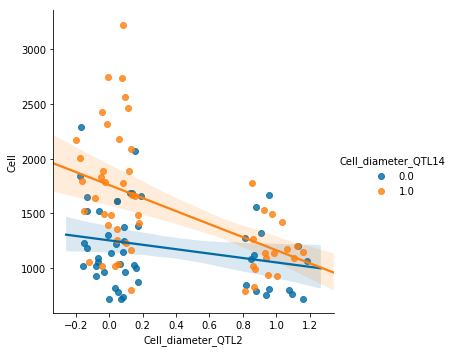

In [137]:
sns.lmplot(x='Cell_diameter_QTL2',y='Cell',
           data=dgg,hue='Cell_diameter_QTL14',x_jitter=0.2);

In [80]:
dgg['Cell_']

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL
Sample,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.00,1093.00,1935.5,61.323907,37.304177,25.117309,15,2.144624,1
SS-B307,SS-B307,7-120,3015.00,831.00,2065.5,61.958189,32.512533,26.994920,15,3.635013,1
SS-B310,SS-B310,7-120,6371.00,2168.00,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0
SS-B311,SS-B311,7-150,3293.50,1023.50,2096.5,64.756295,36.099316,26.319158,15,1.251042,1
SS-B312,SS-B312,11-22,7008.50,1610.00,5398.5,94.452263,45.269625,47.179251,15,3.982097,0
SS-B313,SS-B313,7-150,3343.00,1278.00,2178.0,65.240864,40.337964,27.184889,15,1.820948,0
SS-B314,SS-B314,10-41,10354.00,2561.00,7299.5,114.784553,57.103121,51.795994,15,-3.813783,1
SS-B315,SS-B315,10-25,3101.50,1683.50,1455.5,62.782560,46.291181,17.224005,15,-6.639170,0
SS-B316,SS-B316,11-22,4429.00,1663.50,2646.0,75.088240,46.022103,28.779909,15,-2.595738,1


In [78]:
smf.ols('Cell_diameter ~ ' , data=dgg)

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL
Sample,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.00,1093.00,1935.5,61.323907,37.304177,25.117309,15,2.144624,1
SS-B307,SS-B307,7-120,3015.00,831.00,2065.5,61.958189,32.512533,26.994920,15,3.635013,1
SS-B310,SS-B310,7-120,6371.00,2168.00,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0
SS-B311,SS-B311,7-150,3293.50,1023.50,2096.5,64.756295,36.099316,26.319158,15,1.251042,1
SS-B312,SS-B312,11-22,7008.50,1610.00,5398.5,94.452263,45.269625,47.179251,15,3.982097,0
SS-B313,SS-B313,7-150,3343.00,1278.00,2178.0,65.240864,40.337964,27.184889,15,1.820948,0
SS-B314,SS-B314,10-41,10354.00,2561.00,7299.5,114.784553,57.103121,51.795994,15,-3.813783,1
SS-B315,SS-B315,10-25,3101.50,1683.50,1455.5,62.782560,46.291181,17.224005,15,-6.639170,0
SS-B316,SS-B316,11-22,4429.00,1663.50,2646.0,75.088240,46.022103,28.779909,15,-2.595738,1


In [77]:
smf.ols()

<module 'statsmodels.formula.api' from '/home/croth/anaconda3/lib/python3.7/site-packages/statsmodels/formula/api.py'>

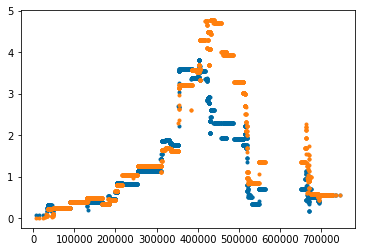

In [70]:
plt.plot(pval_df[(pval_df.Chrom=='Chr14')].Pos.values,
         pval_df[(pval_df.Chrom=='Chr14')].Cell_size.values,'.');

plt.plot(pval_df[(pval_df.Chrom=='Chr14')].Pos.values,
         pval_df[(pval_df.Chrom=='Chr14')].Residual.values,'.');

In [197]:
dgg['QTL2'] = pval_df[dgg.index].T[pval_df[(pval_df.Chrom=='Chr02')]['Cell_size'].idxmax()]

In [194]:
dgg['QTL142'] = pval_df[dgg.index].T[pval_df[(pval_df.Chrom=='Chr14')]['Cell_size'].idxmax()]

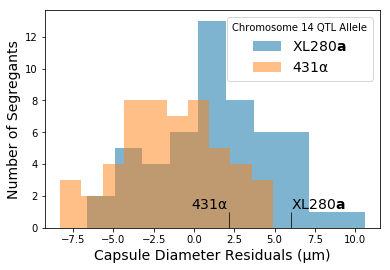

In [133]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

for i, a in enumerate(dgg.groupby('QTL')):
    
    plt.hist(a[1].Residual,alpha=0.5,bins=10,
    label=xl280_label if i == 0 else _431_label);
plt.legend(title='Chromosome 14 QTL Allele',fontsize=14)
plt.vlines(dgg.T[['XL280a','SS-A837']].T.Residual,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Residual,y=1,
         s=_431_label,fontsize=14,va='bottom',ha='right')
plt.text(x=dgg.T['XL280a'].T.Residual,y=1,
         s=xl280_label,fontsize=14,va='bottom',ha='left');
plt.xlabel('Capsule Diameter Residuals (\u03BCm)',fontsize=14);
plt.ylabel('Number of Segregants',fontsize=14);
plt.savefig('/Users/croth/Desktop/DISFIGS/ch4/Cdx_Annulus_Residuals.png',
           dpi=150,bbox_inches='tight');

In [ ]:
assert 1 == 0

In [113]:
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL
Sample,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0


In [141]:
ci95_res[0]

354579.0

In [124]:
myminmax(ch14p.Residual.values)

array([0.        , 0.00491242, 0.0212766 , 0.01189648, 0.01398788,
       0.0440447 , 0.00331577, 0.00912535, 0.02053639, 0.05003091,
       0.08102179, 0.07964014, 0.09858234, 0.09858234, 0.08390609,
       0.07282688, 0.07282688, 0.09577498, 0.08899535, 0.13561493,
       0.16435075, 0.21806795, 0.21806795, 0.20380776, 0.26059321,
       0.26091444, 0.26091444, 0.23476056, 0.28560062, 0.34526418,
       0.3525481 , 0.34951303, 0.34058623, 0.48225681, 0.49593655,
       0.54939184, 0.57057759, 0.62142371, 0.65517609, 0.67046462,
       0.67046462, 0.54685775, 0.74793552, 0.74793552, 0.73698363,
       0.73698363, 0.7726863 , 0.7464142 , 0.69872543, 0.75476427,
       0.90118669, 0.99440018, 0.86110412, 0.97605779, 0.99526388,
       0.90051901, 0.93877577, 0.85299003, 0.85299003, 0.77394302,
       0.93953854, 0.85489517, 0.93280545, 1.        , 1.        ,
       0.98358221, 0.98358221, 0.84059669, 0.84059669, 0.82484748,
       0.82484748, 0.6878059 , 0.63365227, 0.56616515, 0.62909

In [197]:
dgg.shape

(104, 12)

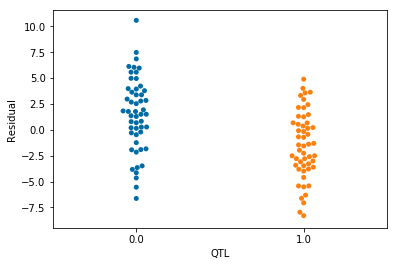

In [202]:
sns.swarmplot(x='QTL',y='Residual',data=dgg);

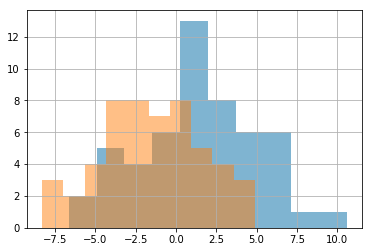

In [201]:
dgg.groupby('QTL').Residual.hist(alpha=0.5);

In [198]:
dgg.to_csv('/Users/croth/Desktop/CRYPTO_QTL/FILES/Capsule_Phenotypes.csv',index=True)

In [ ]:
pval_df.head()

In [ ]:
pval_df[['Chrom','Pos','Residual']
       ].to_csv('/Users/croth/Desktop/CRYPTO_QTL/FILES/Capsule_Pval.csv',
               index=True)

In [ ]:
dgg['Mito'] = [float(a) for a in median_mito[dgg.index].T.values]
dgg['QTL'] = dgg['QTL'].apply(float)

In [ ]:
dgg.head()

In [ ]:
sns.lmplot(x='QTL',y='Residual',hue='Mito',data=dgg)

In [ ]:
median_mito.to_csv('../../FILES/Cdx-mitochondiral-median.csv')

In [ ]:
residual_threshold

In [ ]:
ssa837[y].values

In [ ]:
MelQTL.index = MelQTL.strain

In [ ]:
MelQTL.head()

In [ ]:
dgg['Mel'] = MelQTL.T[dgg.index].T['MC']

In [ ]:
plt.plot(np.argsort(dgg.Mel.values),np.argsort(dgg.Residual.values),'.');

In [ ]:
plt.plot(dgg[(dgg.QTL==0)].Residual,dgg[(dgg.QTL==0)].Mel,'o',color='tab:blue')
plt.plot(dgg[(dgg.QTL==1)].Residual,dgg[(dgg.QTL==1)].Mel,'o',color='tab:orange');

In [ ]:
pval_df[(pval_df.Chrom=='Chr14') & (pval_df.Residual>=residual_threshold) & 
        (pval_df.Pos>=ci95_res[0]) & (pval_df.Pos<=ci95_res[1])].shape

In [ ]:
minpos = pval_df[(pval_df.Chrom=='Chr14') & (pval_df.Residual>=residual_threshold)].Pos.min()
minpos

In [ ]:
maxpos = pval_df[(pval_df.Chrom=='Chr14') & (pval_df.Residual>=residual_threshold)].Pos.max()
maxpos

In [ ]:
left_pos = gv[(gv.Block==gv[(gv.Chrom=='Chr14') & (gv.Pos==minpos)].Block.min())].Pos.min()

In [ ]:
right_pos = gv[(gv.Block==gv[(gv.Chrom=='Chr14') & (gv.Pos==maxpos)].Block.min())].Pos.max()

In [ ]:
chr14_genes = gff[(gff.contig=='Chr14') & (gff.end > left_pos) & (gff.start < right_pos) & (gff.type=='gene')]

In [ ]:
chr14_genes.head()

In [ ]:
chr14_genes.shape

In [ ]:
genes = pd.read_csv('../../FILES/XL280_431_gene_analysis.csv.gz')

In [ ]:
ch14_gene_info = chr14_genes.merge(genes[(genes.chrom=='Chr14')])

In [ ]:
chr14_genes[~(chr14_genes.gene.isin(ch14_gene_info.gene))]

In [ ]:
ch14_gene_info[(ch14_gene_info.missense!=0)][['gene','start','end','strand','phase',
                'attribute','description','nonsense','missense'
                                ]].to_csv('../../FILES/Chr14_genes_with_changes.csv')

In [ ]:
#dggp.reset_index(inplace=True)

In [ ]:
chr14_df = dggp.copy()
chr14_df.columns = ['strain'] + chr14_df.columns[1:].tolist()

In [ ]:
melvr = MelQTL.merge(chr14_df)

In [ ]:
melvr.head()

In [ ]:
melvr[(melvr.strain=='SS-A837')]

In [ ]:
melvr.to_csv('../../FILES/Cdx_capsule_data.csv')

In [ ]:
plt.hist(melvr[(melvr.QTL==0)].Cell,
         color='tab:blue',alpha=0.7,label='XL280');
plt.hist(melvr[(melvr.QTL==1)].Cell,
         color='tab:orange',alpha=0.7,label='431');
plt.ylabel('Number of Segregants');plt.xlabel('Capsule (Full) Diameter')
plt.vlines(melvr[(melvr.strain=='SS-A837')].Cell,0,8,
           color='tab:orange');
plt.vlines(melvr[(melvr.strain.isin(['XL280a','XL280alpha']))].Cell,0,8,
           color='tab:blue',linestyles=['-','--']);

In [ ]:
plt.hist(melvr[(melvr.QTL==0)].Capsule_diameter,
         color='tab:blue',alpha=0.7,label='XL280');
plt.hist(melvr[(melvr.QTL==1)].Capsule_diameter,
         color='tab:orange',alpha=0.7,label='431');
plt.ylabel('Number of Segregants');plt.xlabel('Capsule (Full) Diameter')
plt.vlines(melvr[(melvr.strain=='SS-A837')].Capsule_diameter,0,8,
           color='tab:orange');
plt.vlines(melvr[(melvr.strain.isin(['XL280a','XL280alpha']))].Capsule_diameter,0,8,
           color='tab:blue',linestyles=['-','--']);

In [ ]:
plt.hist(melvr[(melvr.QTL==0)].Residual,
         color='tab:blue',alpha=0.7,label='XL280');
plt.hist(melvr[(melvr.QTL==1)].Residual,
         color='tab:orange',alpha=0.7,label='431');
plt.ylabel('Number of Segregants');plt.xlabel('Residuals')
plt.vlines(melvr[(melvr.strain=='SS-A837')].Residual,0,8,
           color='tab:orange');
plt.vlines(melvr[(melvr.strain.isin(['XL280a','XL280alpha']))].Residual,0,8,
           color='tab:blue',linestyles=['-','--']);

In [ ]:
plt.hist(melvr[(melvr.QTL==0)].Cell_Residual,
         color='tab:blue',alpha=0.7,label='XL280');
plt.hist(melvr[(melvr.QTL==1)].Cell_Residual,
         color='tab:orange',alpha=0.7,label='431');
plt.ylabel('Number of Segregants');plt.xlabel('Residuals')
plt.vlines(melvr[(melvr.strain=='SS-A837')].Cell_Residual,0,8,
           color='tab:orange');
plt.vlines(melvr[(melvr.strain.isin(['XL280a','XL280alpha']))].Cell_Residual,0,8,
           color='tab:blue',linestyles=['-','--']);

In [ ]:
plt.plot(melvr[(melvr.QTL==0)].Residual,
         melvr[(melvr.QTL==0)].MC,
         'o',color='tab:blue',alpha=0.7,label='XL280');
plt.plot(melvr[(melvr.QTL==1)].Residual,
         melvr[(melvr.QTL==1)].MC,
         'o',color='tab:orange',alpha=0.7,label='431');
plt.legend();
plt.ylabel('Mean Intensity\n');
plt.xlabel('Residuals (Annulus Diameter ~ Capsule Diameter)');

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(5,7),sharex=True,sharey=True)
plt.sca(ax[0])
y1 = 'Capsule_diameter'
x = 'Cell_and_Capsule_diameter'
sns.regplot(x=x,y=y1,
           data=melvr,order=1,
           line_kws={'color':'red','alpha':.5}, 
           scatter_kws={'color':'k','alpha':0.5});
plt.xlabel(' ')
plt.ylabel('Diameter of Capsule',fontsize=14)

plt.sca(ax[1])
y2 = 'Cell_diameter'
sns.regplot(x=x,y=y2,
           data=dgg,order=1,
           line_kws={'color':'red','alpha':.5}, 
           scatter_kws={'color':'k','alpha':0.5});
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Diameter of Cell and Capsule',fontsize=14)
plt.ylabel('Diameter of Cell',fontsize=14);
axes = fig.add_axes([1.1,0.3,0.6,0.4])
plt.sca(axes)
#plt.plot(dggp.Cell_Residual,dggp.Residual,'r.');
_431res = melvr[(melvr.QTL==1)]
_xlres = melvr[(melvr.QTL==0)]
plt.plot(_431res.Cell_Residual,_431res.Residual,
         'o',color='tab:orange',alpha=0.5)
plt.plot(_xlres.Cell_Residual,_xlres.Residual,
         'o',color='tab:blue',alpha=0.5);
plt.title('Residuals',fontsize=14)
plt.xlabel('Diameter of Cell',fontsize=14);
plt.ylabel('Diameter of Capsule',fontsize=14);
plt.savefig('../../FIGURES/Cdx_Cell_Capsual_Regression.png',
            dpi=100,bbox_inches='tight');